In [1]:
import gc

%matplotlib notebook 
from matplotlib import pyplot as plt
import numpy as np

from run_for_memory_profile import run_with_limit, generate_fits_files

from ccdproc import __version__ as ccdp_version
from astropy import __version__ as apy_version

In [2]:
image_size = 4000
num_files = 10
sampling_interval = 0.01 # sec
memory_limit = 1000000000
combine_method = 'average'

In [3]:
generate_fits_files(num_files, size=image_size)

In [4]:
runs = {
    combine_method: {
        'times': [],
        'memory': [],
        'image_size': 0.
    }
}

In [5]:
n_repetitions = 4

for _ in range(n_repetitions):
    mem_use, img_size = run_with_limit(num_files, sampling_interval, size=image_size, memory_limit=memory_limit, combine_method=combine_method)
    gc.collect()
    runs[combine_method]['times'].append(np.arange(len(mem_use)) * sampling_interval)
    runs[combine_method]['memory'].append(mem_use)
    runs[combine_method]['image_size'] = img_size
    runs[combine_method]['memory_limit'] = memory_limit


Process ID is:  62228
[477.84375, 477.84375, 477.84375, 477.84375, 477.84375, 477.84375, 477.84375, 477.84375, 477.84375, 477.84375, 477.84375, 477.84375, 477.84375, 477.84375, 477.84375, 477.84375, 477.84375, 477.84375, 477.84375, 477.84375, 477.84375, 477.84375, 477.84375, 477.84375, 477.84375, 477.84375, 477.84375, 477.84375, 477.84375, 477.84375, 477.84375, 477.84375, 477.84375, 477.84375, 477.84375, 477.84375, 477.84375, 477.84375, 477.84375, 477.84375, 477.84375, 477.84375, 477.84375, 477.84375, 477.84375, 477.84375, 477.84375, 477.84375, 477.84375, 477.84375, 477.84375, 477.84375, 477.84375, 477.84375, 477.84375, 477.84375, 477.84375, 477.84375, 477.84375, 477.84375, 477.84375, 477.84375, 477.84375, 477.84375, 477.84375, 477.84375, 477.84375, 477.84375, 477.84375, 477.84375, 477.84375, 477.84375, 477.84375, 477.84375, 477.84375, 477.84375, 477.84375, 477.84375, 477.84375, 477.84375, 477.84375, 477.84375, 477.84375, 477.84375, 477.84375, 477.84375, 477.84375, 477.84375, 477.84375

INFO:astropy:splitting each image into 2 chunks to limit memory usage to 1000000000 bytes.


INFO: splitting each image into 2 chunks to limit memory usage to 1000000000 bytes. [ccdproc.combiner]
Process ID is:  62228
[894.99609375, 894.99609375, 894.99609375, 894.99609375, 894.99609375, 894.99609375, 894.99609375, 894.99609375, 894.99609375, 894.99609375, 894.99609375, 894.99609375, 894.99609375, 894.99609375, 894.99609375, 894.99609375, 894.99609375, 894.99609375, 894.99609375, 894.99609375, 894.99609375, 894.99609375, 894.99609375, 894.99609375, 894.99609375, 894.99609375, 894.99609375, 894.99609375, 894.99609375, 894.99609375, 894.99609375, 894.99609375, 894.99609375, 894.99609375, 894.99609375, 894.99609375, 894.99609375, 894.99609375, 894.99609375, 894.99609375, 894.99609375, 894.99609375, 894.99609375, 894.99609375, 894.99609375, 894.99609375, 894.99609375, 894.99609375, 894.99609375, 894.99609375, 894.99609375, 894.99609375, 894.99609375, 894.99609375, 894.99609375, 894.99609375, 894.99609375, 894.99609375, 894.99609375, 894.99609375, 894.99609375, 894.99609375, 894.99

INFO:astropy:splitting each image into 2 chunks to limit memory usage to 1000000000 bytes.


INFO: splitting each image into 2 chunks to limit memory usage to 1000000000 bytes. [ccdproc.combiner]
Process ID is:  62228
[895.06640625, 895.06640625, 895.06640625, 895.06640625, 895.06640625, 895.06640625, 895.06640625, 895.06640625, 895.06640625, 895.06640625, 895.06640625, 895.06640625, 895.06640625, 895.06640625, 895.06640625, 895.06640625, 895.06640625, 895.06640625, 895.06640625, 895.06640625, 895.06640625, 895.06640625, 895.06640625, 895.06640625, 895.06640625, 895.06640625, 895.06640625, 895.06640625, 895.06640625, 895.06640625, 895.06640625, 895.06640625, 895.06640625, 895.06640625, 895.06640625, 895.06640625, 895.06640625, 895.06640625, 895.06640625, 895.06640625, 895.06640625, 895.06640625, 895.06640625, 895.06640625, 895.06640625, 895.06640625, 895.06640625, 895.06640625, 895.06640625, 895.06640625, 895.06640625, 895.06640625, 895.06640625, 895.06640625, 895.06640625, 895.06640625, 895.06640625, 895.06640625, 895.06640625, 895.06640625, 895.06640625, 895.06640625, 895.06

INFO:astropy:splitting each image into 2 chunks to limit memory usage to 1000000000 bytes.


INFO: splitting each image into 2 chunks to limit memory usage to 1000000000 bytes. [ccdproc.combiner]
Process ID is:  62228
[895.140625, 895.140625, 895.140625, 895.140625, 895.140625, 895.140625, 895.140625, 895.140625, 895.140625, 895.140625, 895.140625, 895.140625, 895.140625, 895.140625, 895.140625, 895.140625, 895.140625, 895.140625, 895.140625, 895.140625, 895.140625, 895.140625, 895.140625, 895.140625, 895.140625, 895.140625, 895.140625, 895.140625, 895.140625, 895.140625, 895.140625, 895.140625, 895.140625, 895.140625, 895.140625, 895.140625, 895.140625, 895.140625, 895.140625, 895.140625, 895.140625, 895.140625, 895.140625, 895.140625, 895.140625, 895.140625, 895.140625, 895.140625, 895.140625, 895.140625, 895.140625, 895.140625, 895.140625, 895.140625, 895.140625, 895.140625, 895.140625, 895.140625, 895.140625, 895.140625, 895.140625, 895.140625, 895.140625, 895.140625, 895.140625, 895.140625, 895.140625, 895.140625, 895.140625, 895.140625, 895.140625, 895.140625, 895.140625

INFO:astropy:splitting each image into 2 chunks to limit memory usage to 1000000000 bytes.


INFO: splitting each image into 2 chunks to limit memory usage to 1000000000 bytes. [ccdproc.combiner]


<IPython.core.display.Javascript object>


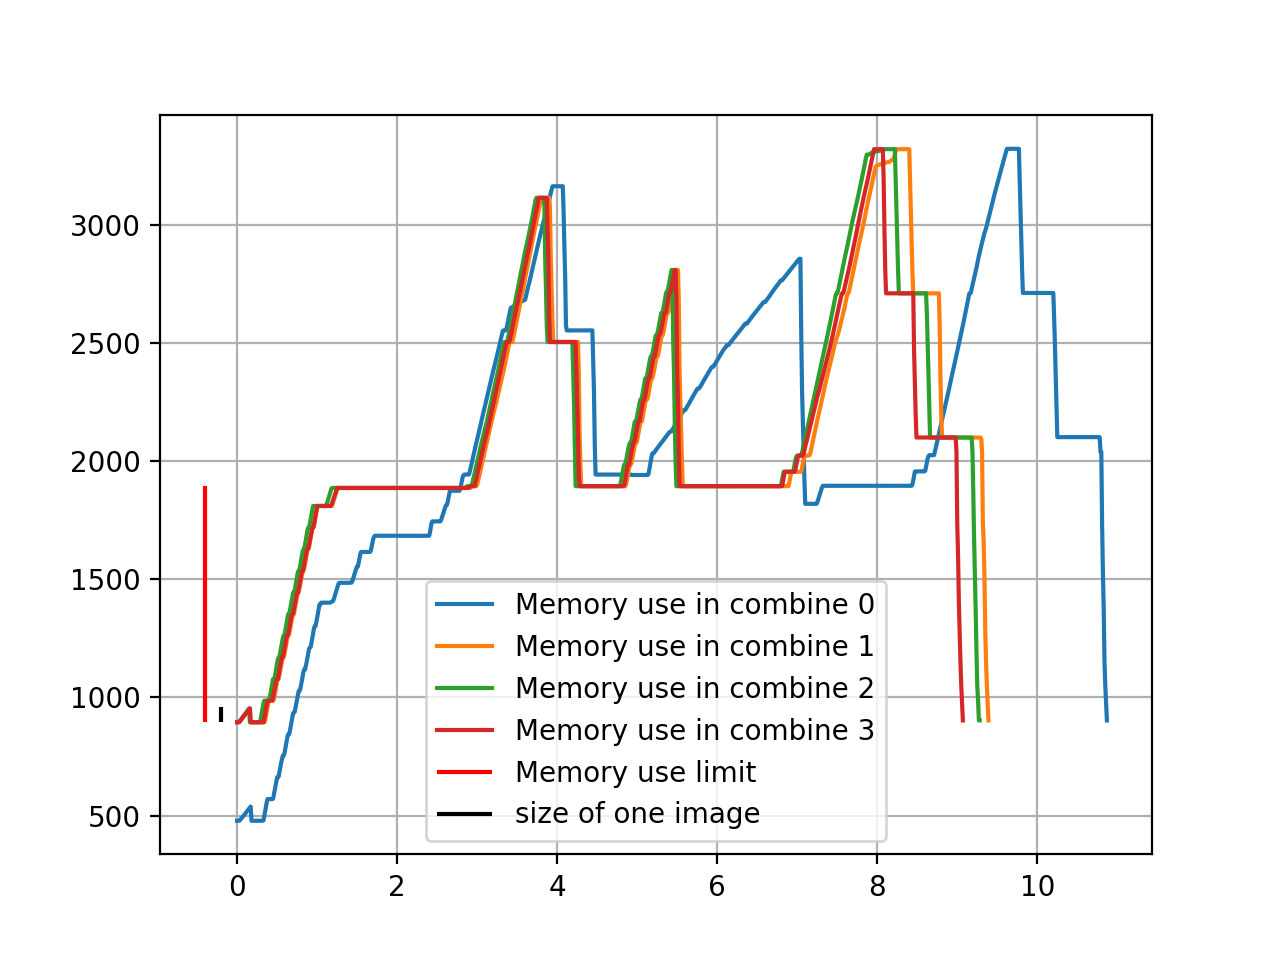

In [6]:
for i, data in enumerate(zip(runs[combine_method]['times'], runs[combine_method]['memory'])):
    time, mem_use = data
    plt.plot(time, mem_use, label='Memory use in combine {}'.format(i))

plt.vlines(-40 * sampling_interval, mem_use[0], mem_use[0] + memory_limit/1e6, colors='red', label='Memory use limit')
plt.vlines(-20 * sampling_interval, mem_use[0], mem_use[0] + img_size/1e6, label='size of one image')
plt.grid()
plt.legend()

In [ ]:
ccdp_version, apy_version